## Installing Required Libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00


In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -q sentencepiece

## Dowload Dataset

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1YMtWesf_wYj1qZnHQyyZ8Rh5UclWFw-R'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YMtWesf_wYj1qZnHQyyZ8Rh5UclWFw-R
To: /content/Dataset.zip
100%|██████████| 344k/344k [00:00<00:00, 111MB/s]


'Dataset.zip'

In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/Restaurants_Train.csv  
  inflating: __MACOSX/Dataset/._Restaurants_Train.csv  
  inflating: Dataset/Restaurants_Test.csv  
  inflating: __MACOSX/Dataset/._Restaurants_Test.csv  
  inflating: Dataset/Laptops_Test.csv  
  inflating: __MACOSX/Dataset/._Laptops_Test.csv  
  inflating: Dataset/Laptops_Train.csv  
  inflating: __MACOSX/Dataset/._Laptops_Train.csv  


## Importing Required Libraries

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer
from transformers import Seq2SeqTrainer
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
from datasets.dataset_dict import DatasetDict
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import os
import warnings
import torch


In [ ]:
from transformers import AutoTokenizer


In [ ]:

class DatasetLoader:
    def __init__(self, train_df_id=None, test_df_id=None, val_df_id=None,
                 train_df_ood=None, test_df_ood=None, val_df_ood=None, sample_size=1):
        self.train_df_id = (
            train_df_id.sample(frac=sample_size, random_state=1999)
            if train_df_id is not None
            else train_df_id
        )
        self.test_df_id = test_df_id
        self.train_df_ood = train_df_ood
        self.test_df_ood = test_df_ood
        self.val_df_id = val_df_id
        self.val_df_ood = val_df_ood

    def _modify_strings(self, df, col):
        modifyed_col = []
        for text in df[col]:
            if text != '[]' and isinstance(text, str):
                text = text.replace('[', '').replace(']', '').replace('{', '').replace('}', '').split(", '")
                req_list = []
                for idx, pair in enumerate(text):
                    splitter = ': ' if ': ' in pair else ':'
                    if idx % 2 == 0:
                        modifyed_dict = {}
                        modifyed_dict[pair.split(splitter)[0].replace("'", '')] = pair.split(splitter)[1].replace("'", '')
                    else:
                        modifyed_dict[pair.split(splitter)[0].replace("'", '')] = pair.split(splitter)[1].replace("'", '')
                        req_list.append(modifyed_dict)
            else:
                req_list = text
            modifyed_col.append(req_list)
        df[col] = modifyed_col
        return df

    def create_data(self, df, key, text_col, aspect_col, bos_instruction='', eos_instruction=''):
        if df is None:
            return
        try:
            df.iloc[0][aspect_col][0][key]
        except:
            df = self._modify_strings(df, aspect_col)
        df['labels'] = df[aspect_col].apply(lambda x: ', '.join([i[key] for i in x]))
        df['text'] = df[text_col].apply(lambda x: bos_instruction + x + eos_instruction)
        return df

    def set_data_for_training(self, tokenize_function):
        dataset_dict_in_domain, dataset_dict_out_domain = {}, {}

        if self.train_df_id is not None:
            dataset_dict_in_domain['train'] = Dataset.from_pandas(self.train_df_id)
        if self.test_df_id is not None:
            dataset_dict_in_domain['test'] = Dataset.from_pandas(self.test_df_id)
        if self.val_df_id is not None:
            dataset_dict_in_domain['validation'] = Dataset.from_pandas(self.val_df_id)

        if len(dataset_dict_in_domain) > 1:
            in_domain_dataset = DatasetDict(dataset_dict_in_domain)
            in_domain_tokenized_datasets = in_domain_dataset.map(tokenize_function, batched=True)
        else:
            in_domain_dataset = {}
            in_domain_tokenized_datasets = {}

        if self.train_df_ood is not None:
            dataset_dict_out_domain['train'] = Dataset.from_pandas(self.train_df_ood)
        if self.test_df_ood is not None:
            dataset_dict_out_domain['test'] = Dataset.from_pandas(self.test_df_ood)
        if self.val_df_ood is not None:
            dataset_dict_out_domain['validation'] = Dataset.from_pandas(self.val_df_ood)

        if len(dataset_dict_out_domain) > 1:
            out_domain_dataset = DatasetDict(dataset_dict_out_domain)
            out_domain_tokenized_dataset = out_domain_dataset.map(tokenize_function, batched=True)
        else:
            out_domain_dataset = {}
            out_domain_tokenized_dataset = {}

        return in_domain_dataset, in_domain_tokenized_datasets, out_domain_dataset, out_domain_tokenized_dataset


In [ ]:

class T5Generator:
    def __init__(self, model_checkpoint):
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
        self.data_collator = DataCollatorForSeq2Seq(self.tokenizer)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def tokenize_function_inputs(self, sample):
        model_inputs = self.tokenizer(sample['text'], max_length=512, truncation=True)
        labels = self.tokenizer(sample["labels"], max_length=64, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    def train(self, tokenized_datasets, **kwargs):
        # Set training arguments
        args = Seq2SeqTrainingArguments(
            **kwargs
        )
        # Define trainer object
        trainer = Seq2SeqTrainer(
            self.model,
            args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets.get("test", None),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
        )
        print("Trainer device:", trainer.args.device)
        # Finetune the model
        torch.cuda.empty_cache()
        print('\nModel training started ....')
        trainer.train()
        # Save best model
        trainer.save_model()
        return trainer

    def get_labels(self, tokenized_dataset, batch_size=4, max_length=128, sample_set='train'):
        def collate_fn(batch):
            input_ids = [torch.tensor(example['input_ids']) for example in batch]
            input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            return input_ids

        dataloader = DataLoader(tokenized_dataset[sample_set], batch_size=batch_size, collate_fn=collate_fn)
        predicted_output = []
        self.model.to(self.device)
        print('Model loaded to: ', self.device)

        for batch in tqdm(dataloader):
            batch = batch.to(self.device)
            output_ids = self.model.generate(batch, max_length=max_length)
            output_texts = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)
            predicted_output.extend(output_texts)
        return predicted_output

    def get_metrics(self, y_true, y_pred, is_triplet_extraction=False):
        total_pred = 0
        total_gt = 0
        tp = 0

        if not is_triplet_extraction:
            for gt, pred in zip(y_true, y_pred):
                gt_list = gt.split(', ')
                pred_list = pred.split(', ')
                total_pred += len(pred_list)
                total_gt += len(gt_list)
                for gt_val in gt_list:
                    for pred_val in pred_list:
                        if pred_val in gt_val or gt_val in pred_val:
                            tp += 1
                            break
        else:
            for gt, pred in zip(y_true, y_pred):
                gt_list = gt.split(', ')
                pred_list = pred.split(', ')
                total_pred += len(pred_list)
                total_gt += len(gt_list)
                for gt_val in gt_list:
                    gt_asp = gt_val.split(':')[0]

                    try:
                        gt_op = gt_val.split(':')[1]
                    except IndexError:
                        continue
                    try:
                        gt_sent = gt_val.split(':')[2]
                    except IndexError:
                        continue
                    for pred_val in pred_list:
                        pr_asp = pred_val.split(':')[0]
                        try:
                            pr_op = pred_val.split(':')[1]
                        except IndexError:
                            continue
                        try:
                            pr_sent = gt_val.split(':')[2]
                        except IndexError:
                            continue
                        if pr_asp in gt_asp and pr_op in gt_op and gt_sent == pr_sent:
                            tp += 1

        precision = tp / total_pred
        recall = tp / total_gt
        f1 = 2 * precision * recall / (precision + recall)
        return precision, recall, f1, None

In [ ]:
task_name = 'AspectExtraction'
experiment_name = 'aspects'
model_checkpoint = 'allenai/tk-instruct-base-def-pos'
print('Experiment Name: ', experiment_name)
model_out_path = './Models'
model_out_path = os.path.join(model_out_path, task_name, f"{model_checkpoint.replace('/', '')}-{experiment_name}")
print('Model output path: ', model_out_path)

Experiment Name:  aspects
Model output path:  ./Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects


### Loading Datasets

In [ ]:
laptop_train = '/content/Dataset/Laptops_Train.csv'
laptop_test = '/content/Dataset/Laptops_Test.csv'
laptop_train_df = pd.read_csv(laptop_train)
laptop_test_df = pd.read_csv(laptop_test)

In [ ]:
laptop_train_df.head()

,sentenceId,raw_text,aspectTerms,aspectCategories
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral'}, {'te...","[{'category': 'noaspectcategory', 'polarity': ..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'noaspectcategory', 'polarity': ..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat...","[{'category': 'noaspectcategory', 'polarity': ..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'noaspectcategory', 'polarity': ..."
4,2193,The other day I had a presentation to do for a...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'noaspectcategory', 'polarity': ..."


In [ ]:
restaurant_train = '/content/Dataset/Restaurants_Train.csv'
restaurant_test = '/content/Dataset/Restaurants_Test.csv'
restaurant_train_df = pd.read_csv(restaurant_train)
restaurant_test_df = pd.read_csv(restaurant_test)

In [ ]:
restaurant_train_df.head()

,sentenceId,raw_text,aspectTerms,aspectCategories
0,3121,But the staff was so horrible to us.,"[{'term': 'staff', 'polarity': 'negative'}]","[{'category': 'service', 'polarity': 'negative'}]"
1,2777,"To be completely fair, the only redeeming fact...","[{'term': 'food', 'polarity': 'positive'}]","[{'category': 'food', 'polarity': 'positive'},..."
2,1634,"The food is uniformly exceptional, with a very...","[{'term': 'food', 'polarity': 'positive'}, {'t...","[{'category': 'food', 'polarity': 'positive'}]"
3,2534,Where Gabriela personaly greets you and recomm...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'service', 'polarity': 'positive'}]"
4,583,"For those that go once and don't enjoy it, all...","[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'anecdotes/miscellaneous', 'pola..."


In [ ]:
len(laptop_train_df),len(restaurant_train_df)

(3045, 3041)

In [ ]:
combined_df = pd.concat([laptop_train_df, restaurant_train_df], ignore_index=True)
combined_df.head()

,sentenceId,raw_text,aspectTerms,aspectCategories
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral'}, {'te...","[{'category': 'noaspectcategory', 'polarity': ..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'noaspectcategory', 'polarity': ..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat...","[{'category': 'noaspectcategory', 'polarity': ..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'noaspectcategory', 'polarity': ..."
4,2193,The other day I had a presentation to do for a...,"[{'term': 'noaspectterm', 'polarity': 'none'}]","[{'category': 'noaspectcategory', 'polarity': ..."


## Aspect Prediction

In [ ]:
len(combined_df)

6086

In [ ]:
combined_df_test = pd.concat([laptop_test_df, restaurant_test_df], ignore_index=True)
combined_df_test.head()
len(combined_df_test)

1600

In [ ]:
loader = DatasetLoader(combined_df, combined_df_test)
if loader.train_df_id is not None:
    loader.train_df_id = loader.create_data(loader.train_df_id, 'term', 'raw_text', 'aspectTerms', '', '')
if loader.test_df_id is not None:
    loader.test_df_id = loader.create_data(loader.test_df_id, 'term', 'raw_text', 'aspectTerms', '', '')

In [ ]:
use_mps = True if torch.has_mps else False
t5_exp = T5Generator(model_checkpoint)

# Tokenize Dataset
id_ds, id_tokenized, ood_ds, ood_tokenized_ds = loader.set_data_for_training(t5_exp.tokenize_function_inputs)

# Training arguments
training_args = {
    'output_dir':model_out_path,
    'evaluation_strategy':"no",
    'learning_rate':5e-5,
    'lr_scheduler_type':'cosine',
    'per_device_train_batch_size':8,
    'per_device_eval_batch_size':16,
    'num_train_epochs':10,
    'weight_decay':0.01,
    'warmup_ratio':0.1,
    'save_strategy':'no',
    'load_best_model_at_end':False,
    'push_to_hub':False,
    'eval_accumulation_steps':1,
    'predict_with_generate':True,
    'use_mps_device':use_mps
}

<ipython-input-16-eb3a27e05440>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  use_mps = True if torch.has_mps else False


Map:   0%|          | 0/6086 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
id_tokenized

DatasetDict({
    train: Dataset({
        features: ['sentenceId', 'raw_text', 'aspectTerms', 'aspectCategories', 'labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6086
    })
    test: Dataset({
        features: ['sentenceId', 'raw_text', 'aspectTerms', 'aspectCategories', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [ ]:
model_trainer = t5_exp.train(id_tokenized, **training_args)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Trainer device: cuda:0

Model training started ....


Step,Training Loss
500,2.293800
1000,0.467500
1500,0.363900
2000,0.273400
2500,0.220100
3000,0.212200
3500,0.159600
4000,0.140900
4500,0.130100
5000,0.109400


In [ ]:
log_history = model_trainer.state.log_history

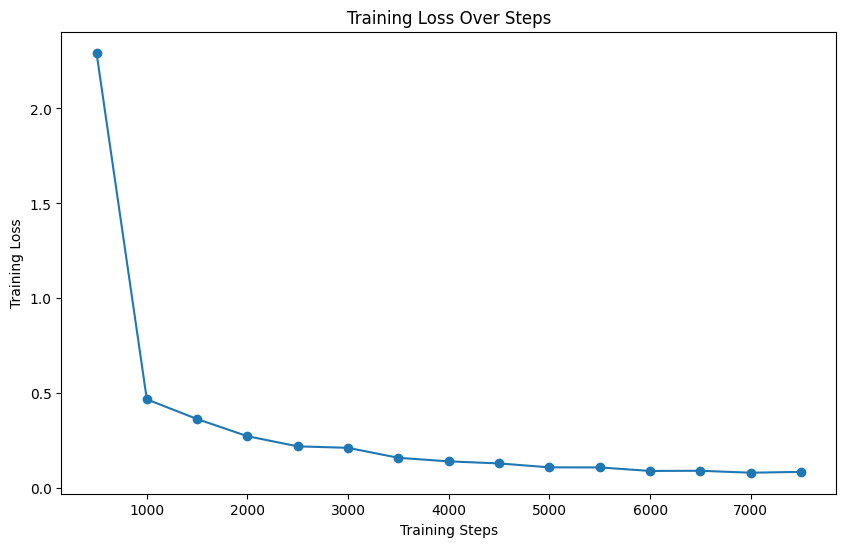

In [ ]:
import matplotlib.pyplot as plt
steps = []
training_losses = []

for log in log_history:
    if 'loss' in log and 'step' in log:
        steps.append(log['step'])
        training_losses.append(log['loss'])

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_losses, marker='o')

# Adding titles and labels
plt.title('Training Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')

# Show the plot
plt.show()

In [ ]:
model_trainer.model.save_pretrained(model_out_path)
t5_exp.tokenizer.save_pretrained(model_out_path)

('./Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects/tokenizer_config.json',
 './Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects/special_tokens_map.json',
 './Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects/spiece.model',
 './Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects/added_tokens.json',
 './Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects/tokenizer.json')

In [ ]:
import shutil
shutil.make_archive(model_out_path, 'zip', model_out_path)

'/content/Models/AspectExtraction/allenaitk-instruct-base-def-pos-aspects.zip'

### Model Evaluation

In [ ]:
# Model inference - Loading from Checkpoint
t5_exp = T5Generator(model_out_path)

# Tokenize Datasets
id_ds, id_tokenized, ood_ds, ood_tokenzed_ds = loader.set_data_for_training(t5_exp.tokenize_function_inputs)

# Get prediction labels - Training set
id_tr_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized, sample_set = 'train',  batch_size = 16)
id_tr_labels = [i.strip() for i in id_ds['train']['labels']]

# Get prediction labels - Testing set
id_te_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized, sample_set = 'test', batch_size = 16)
id_te_labels = [i.strip() for i in id_ds['test']['labels']]

Map:   0%|          | 0/6086 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Model loaded to:  cuda


100%|██████████| 381/381 [01:40<00:00,  3.81it/s]


Model loaded to:  cuda


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


In [ ]:
p, r, f, k = t5_exp.get_metrics(id_tr_labels, id_tr_pred_labels)
print('Train Precision: ', p)
print('Train Recall: ', r)
print('Train F1: ', f)

p, r, f, k = t5_exp.get_metrics(id_te_labels, id_te_pred_labels)
print('Test Precision: ', p)
print('Test Recall: ', r)
print('Test F1: ', f)

Train Precision:  0.9857671835223328
Train Recall:  0.9869091751621872
Train F1:  0.9863378487900891
Test Precision:  0.9510519536281666
Test Recall:  0.9373677528565383
Test F1:  0.9441602728047741


In [ ]:
id_tr_labels[0],id_tr_pred_labels[0]

('noaspectterm', 'noaspectterm')

In [ ]:
import pandas as pd

# Initialize counters
total_count = len(id_tr_labels)
correct_predictions = 0

# Initialize a DataFrame to store results
comparison_matrix = pd.DataFrame(columns=['True Label', 'Predicted Label', 'Is Correct'])

# Compare each label and prediction
for true_label, predicted_label in zip(id_tr_labels, id_tr_pred_labels):
    is_correct = true_label == predicted_label
    correct_predictions += is_correct
    #  comparison_matrix = comparison_matrix.append({'True Label': true_label,
    #                                               'Predicted Label': predicted_label,
    #                                               'Is Correct': is_correct},
    #                                              ignore_index=True)

# Calculate accuracy
accuracy = correct_predictions / total_count
print(f"Accuracy: {accuracy:.2f}")

# Display some of the comparison results


Accuracy: 0.97


### Inference

In [ ]:

t5_exp = T5Generator(model_out_path)

# Step 2: Prepare the input text
# Replace 'your_input_sentence' with your actual input sentence
input_sentence = "The cab ride was amazing but the service was pricey."
model_input = input_sentence

# Step 3: Tokenize the input text
input_ids = t5_exp.tokenizer(model_input, return_tensors="pt").input_ids

# Step 4: Generate predictions
outputs = t5_exp.model.generate(input_ids, max_length=50)  # Adjust max_length as necessary

# Step 5: Decode and interpret the output
predicted_aspects = t5_exp.tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Predicted Aspects:', predicted_aspects)


Predicted Aspects: cab ride, service


In [ ]:
input_sentence = "The food is very good but the quantity is very less"
model_input =   input_sentence

# Step 3: Tokenize the input text
input_ids = t5_exp.tokenizer(model_input, return_tensors="pt").input_ids

# Step 4: Generate predictions
outputs = t5_exp.model.generate(input_ids, max_length=50)  # Adjust max_length as necessary

# Step 5: Decode and interpret the output
predicted_aspects = t5_exp.tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Predicted Aspects:', predicted_aspects)

Predicted Aspects: food, quantity


In [ ]:
input_sentence = "The laptop is very good but the display is not satisfied much"
model_input =  input_sentence

# Step 3: Tokenize the input text
input_ids = t5_exp.tokenizer(model_input, return_tensors="pt").input_ids

# Step 4: Generate predictions
outputs = t5_exp.model.generate(input_ids, max_length=50)  # Adjust max_length as necessary

# Step 5: Decode and interpret the output
predicted_aspects = t5_exp.tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Predicted Aspects:', predicted_aspects)


Predicted Aspects: display


In [ ]:
input_sentence = '''
Pros:
1) Excellent bright screen.
2) Fast processor. Very speedy.
3) Excellent sound.

Cons:
1) Just one major flaw with this phone and it is its poor battery life. It may last a day at most and seems to drain quite quickly.

Excellent phone overall. I love its big screen and using the latest android. Would recommend: 8 out of 10 stars.
'''
model_input =  input_sentence

# Step 3: Tokenize the input text
input_ids = t5_exp.tokenizer(model_input, return_tensors="pt").input_ids

# Step 4: Generate predictions
outputs = t5_exp.model.generate(input_ids, max_length=50)  # Adjust max_length as necessary

# Step 5: Decode and interpret the output
predicted_aspects = t5_exp.tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Predicted Aspects:', predicted_aspects)


Predicted Aspects: screen, processor, sound


# Aspect Sentiment Classification




In [ ]:
if "train" in id_tokenized:
    for i in range(5):
        print(id_tokenized["train"][i])
else:
    print("Training dataset not found in id_tokenized")


{'sentenceId': 1920, 'raw_text': 'I was constantly having to roll back the computer after doing updates.', 'aspectTerms': [{'polarity': 'none', 'term': 'noaspectterm'}], 'aspectCategories': "[{'category': 'noaspectcategory', 'polarity': 'none'}]", 'labels': [150, 9, 5628, 1987, 1], 'text': 'I was constantly having to roll back the computer after doing updates.', '__index_level_0__': 2894, 'input_ids': [27, 47, 4259, 578, 12, 3812, 223, 8, 1218, 227, 692, 3864, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'sentenceId': 2364, 'raw_text': 'Cute place, nice wait staff but would never go there again.', 'aspectTerms': [{'polarity': 'positive', 'term': 'wait staff'}, {'polarity': 'positive', 'term': 'place'}], 'aspectCategories': "[{'category': 'service', 'polarity': 'positive'}, {'category': 'ambience', 'polarity': 'positive'}]", 'labels': [1749, 871, 6, 286, 1], 'text': 'Cute place, nice wait staff but would never go there again.', '__index_level_0__': 4930, 'input_

In [ ]:
# Initialize a list to store the transformed data
transformed_data = []

# Iterate through each entry in your dataset
for entry in id_tokenized['train']:
    sentence = entry['raw_text']
    for aspect_info in entry['aspectTerms']:
        aspect = aspect_info['term']
        sentiment = aspect_info['polarity']
        # Skip 'noaspectterm' entries
        if aspect != 'noaspectterm':
            transformed_data.append({'sentence': sentence, 'aspect': aspect, 'sentiment': sentiment})

# Create a DataFrame from the transformed data
aspect_sentiment_df = pd.DataFrame(transformed_data)


In [ ]:
aspect_sentiment_df.head()

,sentence,aspect,sentiment
0,"Cute place, nice wait staff but would never go...",wait staff,positive
1,"Cute place, nice wait staff but would never go...",place,positive
2,The Macbook arrived in a nice twin packing and...,twin packing,positive
3,The Macbook arrived in a nice twin packing and...,functions,positive
4,It really is perfect for work and play.,play,positive


In [ ]:
# Initialize a list to store the transformed data
transformed_data_test = []

# Iterate through each entry in your dataset
for entry in id_tokenized['test']:
    sentence = entry['raw_text']
    for aspect_info in entry['aspectTerms']:
        aspect = aspect_info['term']
        sentiment = aspect_info['polarity']
        # Skip 'noaspectterm' entries
        if aspect != 'noaspectterm':
            transformed_data_test.append({'sentence': sentence, 'aspect': aspect, 'sentiment': sentiment})

# Create a DataFrame from the transformed data
aspect_sentiment_df_test = pd.DataFrame(transformed_data_test)
aspect_sentiment_df_test.head()

,sentence,aspect,sentiment
0,"Boot time is super fast, around anywhere from ...",Boot time,positive
1,tech support would not fix the problem unless ...,tech support,negative
2,Set up was easy.,Set up,positive
3,Did not enjoy the new Windows 8 and touchscree...,Windows 8,negative
4,Did not enjoy the new Windows 8 and touchscree...,touchscreen functions,negative


In [ ]:
def tokenize_aspect_sentiment_data(examples):
    tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-base-def-pos")
    model_inputs = tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=512)
    labels = tokenizer(examples['aspect'] + " " + examples['sentiment'], padding='max_length', truncation=True, max_length=512)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
tokenized_data = aspect_sentiment_df.apply(tokenize_aspect_sentiment_data, axis=1)


In [ ]:
tokenized_data_test = aspect_sentiment_df_test.apply(tokenize_aspect_sentiment_data, axis=1)


In [ ]:
from transformers import TrainerCallback, TrainerControl, TrainerState

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience: int):
        self.early_stopping_patience = early_stopping_patience
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        # Assuming the metric of interest is 'eval_loss', adjust if necessary
        eval_loss = state.log_history[-1]["eval_loss"]
        if self.best_metric is None or eval_loss < self.best_metric:
            self.best_metric = eval_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1

        if self.patience_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print("Early stopping triggered")


In [ ]:
# Load pre-trained model
model = T5ForConditionalGeneration.from_pretrained("allenai/tk-instruct-base-def-pos")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=2e-5,
        evaluation_strategy="steps",  # Add this line
        eval_steps=500,  # Evaluate every 500 steps

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,  # Add this line
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)  # Adjust the patience as needed

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data,
    eval_dataset=tokenized_data_test,
    callbacks=[early_stopping_callback]  # Add the callback here
)


# Train the model
trainer.train()


Step,Training Loss,Validation Loss
500,0.041100,0.012039
1000,0.008600,0.005724
1500,0.007100,0.005098
2000,0.007100,0.004676
2500,0.006200,0.004578
3000,0.006300,0.004451
3500,0.006200,0.004415


TrainOutput(global_step=3780, training_loss=1.4581645836905828, metrics={'train_runtime': 2517.0199, 'train_samples_per_second': 12.02, 'train_steps_per_second': 1.502, 'total_flos': 2.070232590974976e+16, 'train_loss': 1.4581645836905828, 'epoch': 5.0})

In [ ]:
log_history = trainer.state.log_history

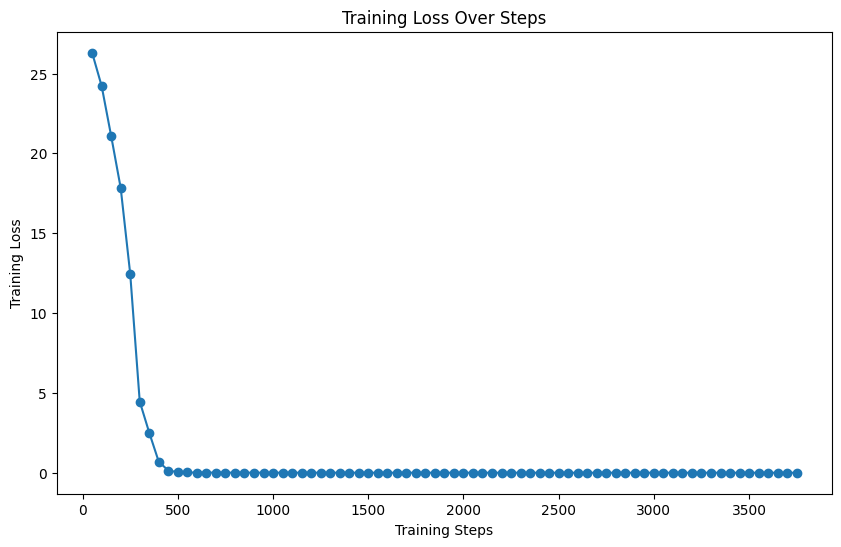

In [ ]:
steps = []
training_losses = []

for log in log_history:
    if 'loss' in log and 'step' in log:
        steps.append(log['step'])
        training_losses.append(log['loss'])

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_losses, marker='o')

# Adding titles and labels
plt.title('Training Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')

# Show the plot
plt.show()

In [ ]:
# Save the model
model.save_pretrained("./AspectSentimentClassifier")

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("./AspectSentimentClassifier")

## Model-2

In [9]:
import torch
from transformers import T5ForConditionalGeneration, T5Config

class CustomT5Model(T5ForConditionalGeneration):
    def __init__(self, config, custom_linear_layer_size=512):
        super().__init__(config)
        # Adding a custom linear layer
        self.custom_linear = torch.nn.Linear(config.d_model, custom_linear_layer_size)
        self.output_layer = torch.nn.Linear(custom_linear_layer_size, config.vocab_size)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        # Standard T5 forward pass
        outputs = super().forward(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            encoder_outputs=encoder_outputs,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        # Pass through the custom linear layer
        sequence_output = self.custom_linear(sequence_output)
        logits = self.output_layer(sequence_output)

        return (logits,) + outputs[1:]

# Initialize the custom model
config = T5Config.from_pretrained('t5-small')
custom_model = CustomT5Model(config)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
)

trainer = Trainer(
    model=custom_model,                   # the instantiated custom model
    args=training_args,                   # training arguments, defined above
   train_dataset=tokenized_data,
    eval_dataset=tokenized_data_test,    # evaluation dataset
)

trainer.train()
custom_model.save_pretrained('./custom_t5_model')
custom_model.save_pretrained('./custom_t5_model')


In [ ]:
def predict_sentiment(test_dataset, model, tokenizer, device="cuda"):
    model.to(device)
    predictions = []

    for item in test_dataset:
        input_ids = torch.tensor([item['input_ids']]).to(device)
        attention_mask = torch.tensor([item['attention_mask']]).to(device)

        with torch.no_grad():
            output = model.generate(input_ids, attention_mask=attention_mask, max_length=50)

        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(prediction)

    return predictions

# Run inference
tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-base-def-pos")
device = "cuda" if torch.cuda.is_available() else "cpu"
predictions = predict_sentiment(tokenized_data_test, model, tokenizer, device)


In [ ]:
def predict_sentiment(test_data, model, device="cuda"):
    model.to(device)
    predictions = []
    for i in range(len(test_data)):
        item = test_data.iloc[i]
        input_ids = torch.tensor([item['input_ids']], device=device)
        attention_mask = torch.tensor([item['attention_mask']], device=device)

        with torch.no_grad():
            output = model.generate(input_ids, attention_mask=attention_mask, max_length=50)
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(prediction)

    return predictions

# Run inference
predictions = predict_sentiment(tokenized_data_test, model, device)

for i, prediction in enumerate(predictions[:5]):
    print(f"Entry {i}: Predicted Sentiment - {prediction}")


Entry 0: Predicted Sentiment - Boot time positive
Entry 1: Predicted Sentiment - tech support negative
Entry 2: Predicted Sentiment - Set up positive
Entry 3: Predicted Sentiment - Windows 8 negative
Entry 4: Predicted Sentiment - Windows 8 negative


In [ ]:
tokenized_data_test

0       [input_ids, attention_mask, labels]
1       [input_ids, attention_mask, labels]
2       [input_ids, attention_mask, labels]
3       [input_ids, attention_mask, labels]
4       [input_ids, attention_mask, labels]
                       ...                 
1783    [input_ids, attention_mask, labels]
1784    [input_ids, attention_mask, labels]
1785    [input_ids, attention_mask, labels]
1786    [input_ids, attention_mask, labels]
1787    [input_ids, attention_mask, labels]
Length: 1788, dtype: object

In [ ]:
new_sentence = "The battery life of this laptop is incredible, but the keyboard is hard to use."
t5_exp = T5Generator(model_out_path)
model_input =  new_sentence
input_ids = t5_exp.tokenizer(model_input, return_tensors="pt").input_ids
outputs = t5_exp.model.generate(input_ids, max_length=50)  # Adjust max_length as necessary
predicted_aspects = t5_exp.tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Predicted Aspects:', predicted_aspects)
aspects = predicted_aspects.split(", ")

from transformers import AutoTokenizer, T5ForConditionalGeneration
import torch

tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-base-def-pos")
tokenized_inputs = []

for aspect in aspects:
    combined_input = f"{new_sentence} [aspect] {aspect}"
    inputs = tokenizer(combined_input, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    tokenized_inputs.append(inputs)

# Load the trained model
model = T5ForConditionalGeneration.from_pretrained("./AspectSentimentClassifier")
model.eval()  # Set the model to evaluation mode
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

predicted_sentiments = []

for inputs in tokenized_inputs:
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=50)

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted_sentiments.append(prediction)

for aspect, sentiment in zip(aspects, predicted_sentiments):
    print(f"Aspect: {aspect}, Predicted Sentiment: {sentiment}")

Predicted Aspects: battery life, keyboard
Aspect: battery life, Predicted Sentiment: keyboard negative
Aspect: keyboard, Predicted Sentiment: battery life negative


In [ ]:
new_sentence = '''
Pros:
1) Excellent bright screen.
2) Fast processor. Very speedy.
3) Excellent sound.

Cons:
1) Just one major flaw with this phone and it is its poor battery life. It may last a day at most and seems to drain quite quickly.

Excellent phone overall. I love its big screen and using the latest android. Would recommend: 8 out of 10 stars.
'''
t5_exp = T5Generator(model_out_path)
model_input =  new_sentence
input_ids = t5_exp.tokenizer(model_input, return_tensors="pt").input_ids
outputs = t5_exp.model.generate(input_ids, max_length=50)  # Adjust max_length as necessary
predicted_aspects = t5_exp.tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Predicted Aspects:', predicted_aspects)
aspects = predicted_aspects.split(", ")

from transformers import AutoTokenizer, T5ForConditionalGeneration
import torch

tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-base-def-pos")
tokenized_inputs = []

for aspect in aspects:
    combined_input = f"{new_sentence} [aspect] {aspect}"
    inputs = tokenizer(combined_input, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    tokenized_inputs.append(inputs)

# Load the trained model
model = T5ForConditionalGeneration.from_pretrained("./AspectSentimentClassifier")
model.eval()  # Set the model to evaluation mode
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

predicted_sentiments = []

for inputs in tokenized_inputs:
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=50)

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted_sentiments.append(prediction)

for aspect, sentiment in zip(aspects, predicted_sentiments):
    print(f"Aspect: {aspect}, Predicted Sentiment: {sentiment}")

Predicted Aspects: screen, processor, sound
Aspect: screen, Predicted Sentiment: processor positive
Aspect: processor, Predicted Sentiment: processor positive
Aspect: sound, Predicted Sentiment: processor positive


# Using Predefined Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("kevinscaria/joint_tk-instruct-base-def-pos-neg-neut-combined")
model = AutoModelForSeq2SeqLM.from_pretrained("kevinscaria/joint_tk-instruct-base-def-pos-neg-neut-combined")

bos_instruction = """Definition: The output will be the aspects (both implicit and explicit) and the aspects sentiment polarity. In cases where there are no aspects the output should be noaspectterm:none.
    Positive example 1-
    input: I charge it at night and skip taking the cord with me because of the good battery life.
    output: battery life:positive,
    Positive example 2-
    input: I even got my teenage son one, because of the features that it offers, like, iChat, Photobooth, garage band and more!.
    output: features:positive, iChat:positive, Photobooth:positive, garage band:positive
    Negative example 1-
    input: Speaking of the browser, it too has problems.
    output: browser:negative
    Negative example 2-
    input: The keyboard is too slick.
    output: keyboard:negative
    Neutral example 1-
    input: I took it back for an Asus and same thing- blue screen which required me to remove the battery to reset.
    output: battery:neutral
    Neutral example 2-
    input: Nightly my computer defrags itself and runs a virus scan.
    output: virus scan:neutral
    Now complete the following example-
    input: """
delim_instruct = ''
eos_instruct = ' \noutput:'
text = 'The food is very good but the quantity is very less'

tokenized_text = tokenizer(bos_instruction + text + delim_instruct + eos_instruct, return_tensors="pt")
output = model.generate(tokenized_text.input_ids)
print('Model output: ', tokenizer.decode(output[0], skip_special_tokens=True))

tokenizer_config.json:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Model output:  food:positive, quantity:negative


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("kevinscaria/joint_tk-instruct-base-def-pos-neg-neut-combined")
model = AutoModelForSeq2SeqLM.from_pretrained("kevinscaria/joint_tk-instruct-base-def-pos-neg-neut-combined")

bos_instruction = """Definition: The output will be the aspects (both implicit and explicit) and the aspects sentiment polarity. In cases where there are no aspects the output should be noaspectterm:none.
    Positive example 1-
    input: I charge it at night and skip taking the cord with me because of the good battery life.
    output: battery life:positive,
    Positive example 2-
    input: I even got my teenage son one, because of the features that it offers, like, iChat, Photobooth, garage band and more!.
    output: features:positive, iChat:positive, Photobooth:positive, garage band:positive
    Negative example 1-
    input: Speaking of the browser, it too has problems.
    output: browser:negative
    Negative example 2-
    input: The keyboard is too slick.
    output: keyboard:negative
    Neutral example 1-
    input: I took it back for an Asus and same thing- blue screen which required me to remove the battery to reset.
    output: battery:neutral
    Neutral example 2-
    input: Nightly my computer defrags itself and runs a virus scan.
    output: virus scan:neutral
    Now complete the following example-
    input: """
delim_instruct = ''
eos_instruct = ' \noutput:'
output = "jj"
text = 'The food is very bad but the quantity is very less and the appetizers is awesome'

tokenized_text = tokenizer(bos_instruction + text + delim_instruct + eos_instruct, return_tensors="pt")
output = model.generate(tokenized_text.input_ids)
print('Model output: ', tokenizer.decode(output[0], skip_special_tokens=True))

Model output:  food:negative, quantity:negative, appetizers:positive


# Summarization

In [6]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

def text_rank_summary(document, max_sentences=3):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(document)
    tokens = [token.text for token in doc]
    word_frequencies = {}
    for word in doc:
        if word.text.lower() not in STOP_WORDS:
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1

    max_frequency = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/max_frequency)

    sentence_scores = {}
    for sent in doc.sents:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent] += word_frequencies[word.text.lower()]

    summarized_sentences = nlargest(max_sentences, sentence_scores, key=sentence_scores.get)
    final_sentences = [w.text for w in summarized_sentences]
    summary = ' '.join(final_sentences)
    return summary

# Example usage
document = '''
Pros:
1) Excellent bright screen.
2) Fast processor. Very speedy.
3) Excellent sound.

Cons:
1) Just one major flaw with this phone and it is its poor battery life. It may last a day at most and seems to drain quite quickly.

Excellent phone overall. I love its big screen and using the latest android. Would recommend: 8 out of 10 stars.
'''
extractive_summary = text_rank_summary(document)
from transformers import BartForConditionalGeneration, BartTokenizer

def bart_summarize(text):
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage
abstractive_summary = bart_summarize(extractive_summary)


In [7]:
extractive_summary

'\nPros:\n1) Excellent bright screen.\n Cons:\n1) Just one major flaw with this phone and it is its poor battery life. Very speedy.\n3) Excellent sound.\n\n'

In [8]:
abstractive_summary

'The iPhone 6 has an excellent bright screen. The phone is very speedy and has a very good sound. It has a poor battery life, but is otherwise a great phone. The iPhone 6 is available in black and white and comes in at a price tag of $649.'

In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [2]:
# Example data
aspects_sentiments = [("battery", "positive"), ("keyboard", "negative"), ("display", "neutral")]

# Prepare the input text
input_text = " ".join([f"The sentiment about {aspect} is {sentiment}." for aspect, sentiment in aspects_sentiments])
print(input_text)  # This is just to visualize what goes into the model


The sentiment about battery is positive. The sentiment about keyboard is negative. The sentiment about display is neutral.


In [3]:
# Tokenize input text
inputs = tokenizer([input_text], max_length=1024, return_tensors='pt', truncation=True)

# Generate summary
summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=200, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(summary)


The sentiment about battery is positive. The sentiment about keyboard is negative. The mood about display is neutral. The view of the user of the keyboard is more positive than that of the display. The views of the screen are more negative than those of the battery. The overall sentiment is positive about the keyboard.
